# Credit Card Default Demo

In [87]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), '..'))

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from sklearn import linear_model
from recourse_methods import mrmc_method, dice_method
from core import recourse_iterator
from data import data_loader
from data.adapters import continuous_adapter
from core import utils
from models import model_interface, model_loader, model_constants
from visualize.two_d_plots import Display2DPaths

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the data and model

In [88]:
dataset, dataset_info = data_loader.load_data(data_loader.DatasetName.CREDIT_CARD_DEFAULT)
adapter = continuous_adapter.StandardizingAdapter(label_column=dataset_info.label_column, positive_label=dataset_info.positive_label).fit(dataset)
dataset

,LIMIT_BAL,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Y
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,24,2,2,0,0,0,0,3913,3102,...,0,0,0,0,689,0,0,0,0,1
2,120000,26,0,2,0,0,0,2,2682,1725,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,34,0,0,0,0,0,0,29239,14027,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,37,0,0,0,0,0,0,46990,48233,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,57,0,0,0,0,0,0,8617,5670,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29996,220000,39,0,0,0,0,0,0,188948,192815,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29997,150000,43,0,0,0,0,0,0,1683,1828,...,8979,5190,0,1837,3526,8998,129,0,0,0
29998,30000,37,4,3,2,0,0,0,3565,3356,...,20878,20582,19357,0,0,22000,4200,2000,3100,1


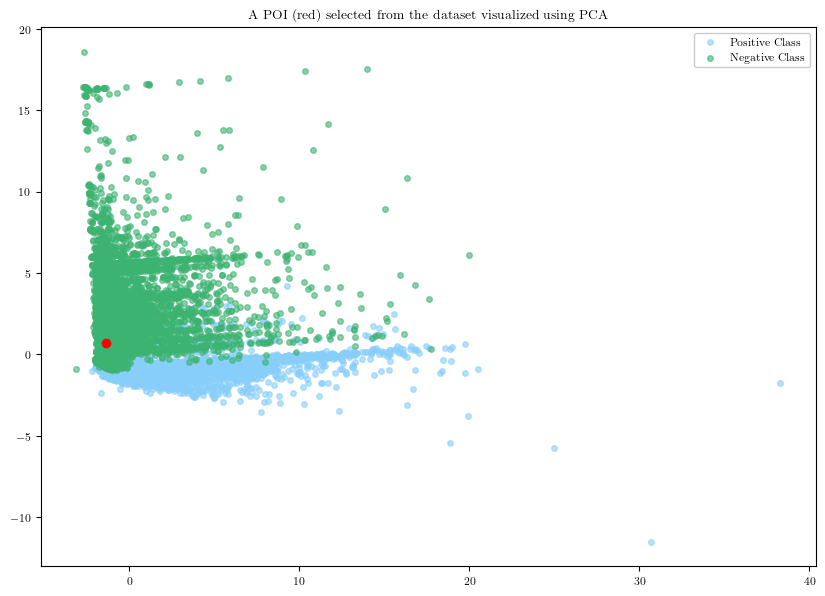

In [89]:
model = model_loader.load_model(
    model_type=model_constants.ModelType.LOGISTIC_REGRESSION,
    dataset_name=data_loader.DatasetName.CREDIT_CARD_DEFAULT,
    model_name=model_constants.ModelName.DEFAULT)

dataset[dataset_info.label_column] = model.predict(dataset)

poi = utils.random_poi(dataset, label_column='Y', label_value=adapter.negative_label)

fig, ax = Display2DPaths(
    adapter.transform(dataset.drop('Y', axis=1)).to_numpy(),
    dataset['Y'].to_numpy(),
    positive_label = dataset_info.positive_label,
    title="A POI (red) selected from the dataset visualized using PCA"
).set_poi(adapter.transform_series(poi)).do_pca().scatter()

## Generate some recourse directions

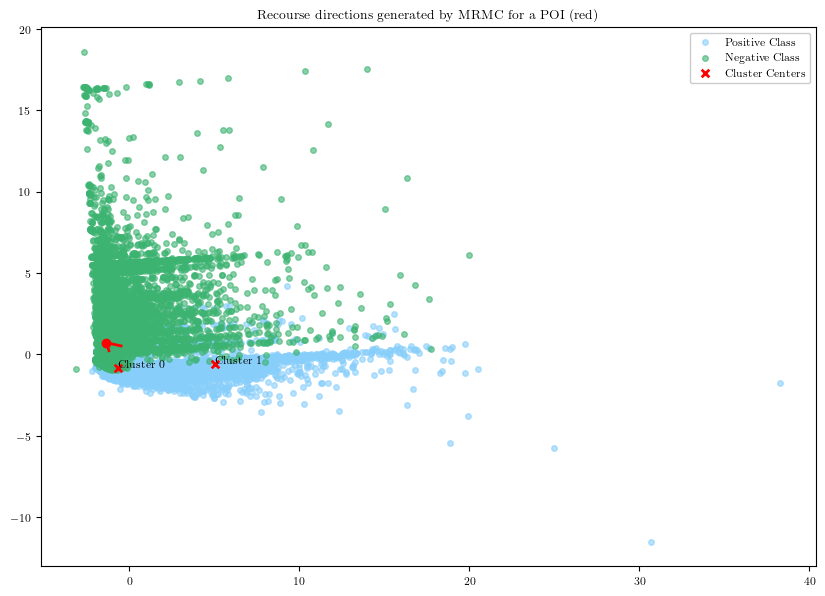

In [90]:
k_directions = 2
mrmc = mrmc_method.MRMC(
    k_directions,
    adapter,
    dataset,
    rescale_direction=mrmc_method.get_constant_step_size_rescaler(1))
poix = adapter.transform_series(poi)
dirs = mrmc.get_all_recourse_directions(poix)

fig, ax = Display2DPaths(
    adapter.transform(dataset.drop('Y', axis=1)).to_numpy(),
    dataset['Y'].to_numpy(),
    positive_label=dataset_info.positive_label,
    title="Recourse directions generated by MRMC for a POI (red)"
).do_pca().set_poi(poix).set_dirs(dirs, poix).set_clusters(mrmc.clusters.cluster_centers).scatter()

## Generate some paths

final certainty for path 0: 0.5184668036729458
final certainty for path 1: 0.5218142618441989


(<Figure size 1000x700 with 1 Axes>,
 <AxesSubplot:title={'center':'Iterated recourse paths generated by MRMC for a POI (red)'}>)

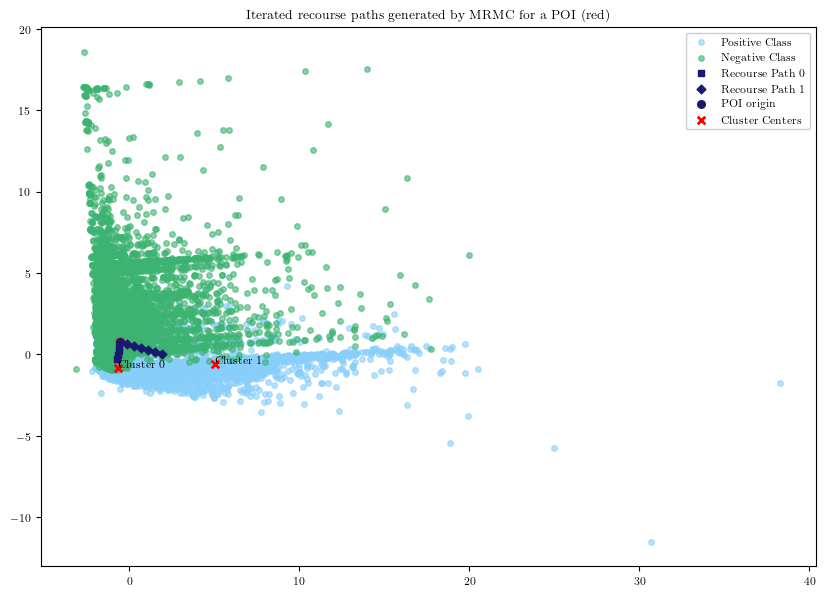

In [91]:
mrmc = mrmc_method.MRMC(
    k_directions,
    adapter,
    dataset,
    rescale_direction=mrmc_method.get_constant_step_size_rescaler(0.5))

display = Display2DPaths(
    adapter.transform(dataset.drop('Y', axis=1)).to_numpy(),
    dataset['Y'].to_numpy(),
    positive_label=dataset_info.positive_label,
    title="Iterated recourse paths generated by MRMC for a POI (red)"
)

poi = utils.random_poi(dataset, label_column='Y', label_value = 1)

iterator = recourse_iterator.RecourseIterator(
    mrmc,
    adapter,
    certainty_cutoff=0.5,
    model=model)
paths = iterator.iterate_k_recourse_paths(poi, 10)

for i, path in enumerate(paths):
    print(f'final certainty for path {i}: {model.predict_pos_proba_series(path.iloc[-1])}')

transformed_paths = [adapter.transform(path) for path in paths]

display.do_pca().set_poi(adapter.transform_series(poi)).set_paths(transformed_paths).set_clusters(mrmc.clusters.cluster_centers).scatter()

## What features are changed?

In [92]:
paths[0]

,LIMIT_BAL,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,50000.000000,42.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,51047.000000,47924.000000,49053.000000,50106.000000,17756.000000,18072.000000,0.000000,2200.000000,2180.000000,1000.000000,1000.000000,800.000000
1,65543.612568,40.944138,0.836062,1.678891,0.008288,0.006081,0.003144,0.005511,47644.780469,44607.499109,45174.290888,45529.861514,18138.176731,18232.830952,612.486172,2472.947591,2358.129466,1312.973290,1311.604938,1167.159494
2,80561.378385,39.884786,0.672108,1.356907,0.015614,0.011455,0.005883,0.010334,44183.105990,41234.519606,41238.634852,40898.949959,18460.610187,18333.491460,1202.995410,2722.209458,2514.513977,1604.162308,1601.998612,1508.743918
3,94792.933679,38.815404,0.508496,1.033723,0.021522,0.015788,0.008047,0.014165,40622.522583,37767.787169,37211.099156,36184.127312,18683.360750,18335.386200,1761.744450,2937.026471,2639.877914,1864.353988,1862.226663,1814.691692
4,107818.667334,37.719092,0.345806,0.709332,0.025314,0.018559,0.009375,0.016545,36866.335766,34115.283867,33007.296778,31314.835835,18721.914301,18157.274553,2271.434234,3099.310661,2718.292430,2077.792394,2077.047654,2068.217064


In [93]:
paths[1]

,LIMIT_BAL,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,50000.000000,42.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,51047.000000,47924.000000,49053.000000,50106.000000,17756.000000,18072.000000,0.000000,2200.000000,2180.000000,1000.000000,1000.000000,800.000000
1,67878.931874,41.486920,0.905881,1.811052,0.004201,0.003693,0.003279,0.005797,61821.068103,58603.273093,59071.494475,58899.071148,28625.927692,28433.391408,1011.002770,3004.043964,2810.345383,1661.222979,1655.988844,1453.603857
2,85638.239896,40.966705,0.810817,1.620296,0.008267,0.007250,0.006405,0.011399,72573.163392,69253.986549,69057.038060,67661.959183,39496.631814,38798.610323,1992.714313,3774.452889,3412.682659,2299.559319,2290.028275,2085.507761
3,103235.382325,40.437018,0.714570,1.427271,0.012131,0.010607,0.009313,0.016705,83288.940922,79861.540787,78995.827168,76384.878284,50368.594995,49170.460987,2939.121218,4504.063490,3981.877222,2910.612402,2897.846671,2691.586964
4,120605.213262,39.894287,0.616805,1.231326,0.015681,0.013664,0.011905,0.021555,93944.850878,90402.704767,88866.538099,85053.145647,61242.527008,59553.732793,3842.328205,5183.443804,4511.294752,3488.597288,3473.846094,3266.421317
5,137642.826609,39.332850,0.517045,1.031526,0.018746,0.016264,0.014040,0.025704,104501.161651,100839.403731,98635.166981,93643.983832,72119.611904,69957.036028,4691.563014,5799.765649,4992.033355,4025.609757,4010.407824,3802.627914
6,154169.578755,38.743398,0.414589,0.826499,0.021047,0.018169,0.015506,0.028761,114888.723480,111107.302407,108245.716817,102121.271429,83002.356018,80396.905118,5471.322911,6334.834803,5411.553878,4510.331874,4496.652549,4289.705582


# Now try DiCE

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s]


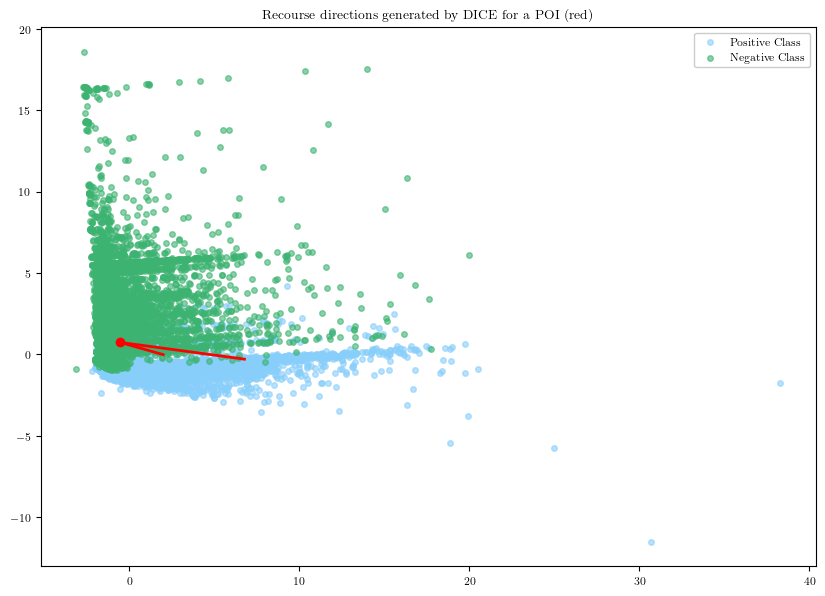

In [94]:
k_directions = 2
dice = dice_method.DiCE(
    k_directions,
    adapter,
    dataset,
    continuous_features=dataset_info.continuous_features,
    model=model,
    desired_confidence=0.5)

poix = adapter.transform_series(poi)
dirs = dice.get_all_recourse_directions(poix)

fig, ax = Display2DPaths(
    adapter.transform(dataset.drop('Y', axis=1)).to_numpy(),
    dataset['Y'].to_numpy(),
    positive_label=dataset_info.positive_label,
    title="Recourse directions generated by DICE for a POI (red)"
).do_pca().set_poi(poix).set_dirs(dirs, poix).scatter()

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.67it/s]


final certainty for path 0: 0.6770427660397785
final certainty for path 1: 0.9660608972300372


(<Figure size 1000x700 with 1 Axes>,
 <AxesSubplot:title={'center':'Iterated recourse paths generated by DICE for a POI (red)'}>)

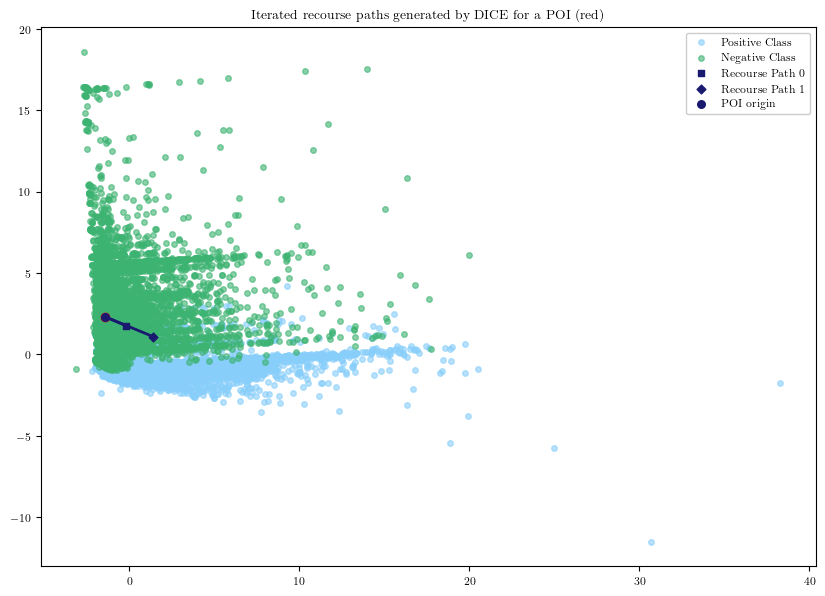

In [95]:
dice = dice_method.DiCE(
    k_directions,
    adapter,
    dataset,
    continuous_features=dataset_info.continuous_features,
    model=model,
    desired_confidence=0.5)

display = Display2DPaths(
    adapter.transform(dataset.drop('Y', axis=1)).to_numpy(),
    dataset['Y'].to_numpy(),
    positive_label=dataset_info.positive_label,
    title="Iterated recourse paths generated by DICE for a POI (red)"
)

poi = utils.random_poi(dataset, label_column='Y', label_value = 1)

iterator = recourse_iterator.RecourseIterator(
    dice,
    adapter,
    certainty_cutoff=0.5,
    model=model)
paths = iterator.iterate_k_recourse_paths(poi, 10)

for i, path in enumerate(paths):
    print(f'final certainty for path {i}: {model.predict_pos_proba_series(path.iloc[-1])}')

transformed_paths = [adapter.transform(path) for path in paths]

display.do_pca().set_poi(adapter.transform_series(poi)).set_paths(transformed_paths).scatter()